In [1]:
import os
import json
from importlib import reload
import warnings

import scipy
import numpy as np
import pandas as pd
import xarray as xr
from scipy.optimize import least_squares
from matplotlib import pyplot as plt
import lmfit

import decoherence as dc

reload(dc)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=scipy.integrate.IntegrationWarning)


# Device parameters 

In [3]:
#sensitivity data for different fx, at the fz points where T2 measurement is taken
with open("DeviceParameters/sensitivityData.json", "r") as f:
    dHdfData = np.array(json.load(f))

In [51]:
# sensitivity data for different fx, along fz symmetry points
with open("DeviceParameters/fxSensitivitySweep.json", "r") as f:
    fx_sensitivity_data = json.load(f)

#sensitivity data for different fz at each fx. 
fz_sensitivity_data = []
for fx in [0.32, 0.36, 0.40]:
    with open(f"DeviceParameters/{fx:.2f}sensitivitySweep.json", "r") as f:
        fz_sensitivity_data.append(json.load(f))


keys = ["dHdfz0011", "dHdfx0011", "|dHdfz01|", "|dHdfx01|"]
fx_sensitivity_da = xr.Dataset(
    data_vars = {
            key: ("fx", [d["Average"][key] for d in fx_sensitivity_data["Data"]]) for key in keys
    },
    coords = {"fx": fx_sensitivity_data["SweepSpecifiers"][0][1]}
)

In [5]:
# device and wiring data for bias line noise
with open("DeviceParameters/raw_data.json", "r") as f:
    ds = json.load(f)

# T2

## prepare T2 data for fitting

In [37]:
#import experiment data and prepare simulated sensitivities
fxs = [32, 36, 40]
T2_fz_data = [pd.read_excel(f"Data/fx{st}RA.xls", index_col=0).to_xarray() for st in fxs]

T2_fz_data[0]["dHdfz0011"] = ("fz", dHdfData[:len(T2_fz_data[0]["fz"]), 2])
T2_fz_data[0]["dHdfx0011"] = ("fz", dHdfData[:len(T2_fz_data[0]["fz"]), 3])
T2_fz_data[1]["dHdfz0011"] = ("fz", dHdfData[18:29, 2])
T2_fz_data[1]["dHdfx0011"] = ("fz", dHdfData[18:29, 3])
T2_fz_data[2]["dHdfz0011"] = ("fz", dHdfData[29:, 2])
T2_fz_data[2]["dHdfx0011"] = ("fz", dHdfData[29:, 3])
T2_fz_data[0]

<xarray.Dataset>
Dimensions:    (fz: 18)
Coordinates:
  * fz         (fz) float64 0.5077 0.5087 0.5097 0.5107 ... 0.5227 0.5237 0.5247
Data variables: (12/20)
    fz_exp     (fz) float64 0.506 0.507 0.508 0.509 ... 0.52 0.521 0.522 0.523
    A          (fz) int64 506 507 508 509 510 511 ... 518 519 520 521 522 523
    A_err      (fz) float64 0.5574 0.5532 0.476 0.3027 ... 0.3329 0.3066 0.2895
    y0         (fz) float64 0.7541 0.7613 0.7617 ... 0.3186 0.07494 0.1411
    y0_err     (fz) float64 0.09027 0.09218 0.08421 ... 0.06606 0.04855 0.04831
    F          (fz) float64 0.02521 0.02482 0.02677 ... 0.02289 0.02101 0.02185
    ...         ...
    G2         (fz) float64 2.319e+07 2.2e+07 2.042e+07 ... 2.37e+07 2.171e+07
    G2err      (fz) float64 3.056e+05 2.77e+05 2.66e+05 ... 2.51e+06 1.061e+06
    Chisq      (fz) float64 1.194 1.246 1.052 0.5228 ... 0.6449 0.3385 0.3394
    Rsq        (fz) float64 0.9869 0.988 0.9873 0.9657 ... 0.9688 0.5328 0.8444
    dHdfz0011  (fz) float64 -82.39 -77.61 -71.93 -65.32 ... 52.51 60.61 67.82
    dHdfx0011  (fz) float64 33.94 36.34 38.57 40.56 ... 33.49 30.24 26.8 23.22

## T2 fit

In [23]:
def cost_func(x, alpha=1, N=0, plot=False, include_error=True):
    Afzprime, Afx, cfzprimefx = x
    estimated_T2s = []
    res = []
    for fxi, fx in enumerate([0.32, 0.36, 0.40]):
        estimated_T2s_per_fx = []
        for fzi, fz in enumerate((T2_fz_data[fxi]["fz"])):
            data = T2_fz_data[fxi].sel(fz=fz, method="nearest")
            T2R = dc.dephasing_tunable_csfq_flux_noise(
                float(data["dHdfz0011"]) * 2 * np.pi * 1e9,
                float(data["dHdfx0011"]) * 2 * np.pi * 1e9,
                Afzprime * 1e-6,
                Afx * 1e-6,
                cfzprimefx,
                omega_low = 2 * np.pi / (1000 * 100e-6),
                tau = 100e-9,
                N=N,
                alpha=alpha
                )
            estimated_T2s_per_fx.append(T2R)
            if include_error:
                res.append((T2R * 1e9 - T2_fz_data[fxi]["T2"][fzi]) / np.array(T2_fz_data[fxi]["T2_err"][fzi]))
            else:
                res.append((T2R * 1e9 - T2_fz_data[fxi]["T2"][fzi]))
        estimated_T2s.append(estimated_T2s_per_fx)
    
    if plot:
        #print (estimated_dephasings)
        #fig, axes = plt.subplots(ncols=len(fx_data), nrows=1, figsize=(7, 4))
        fig, ax = plt.subplots()
        #for i, ax in enumerate(axes):
        for i in range(len(T2_fz_data)):
            (T2_fz_data[i]["T2"] * 1e-9).plot(ax=ax, marker="*")
            ax.plot(T2_fz_data[i]["fz"], estimated_T2s[i])
            ax.grid(True)
    return res


[12.24921009  7.42240152  0.17248251]


0.43470004713124566

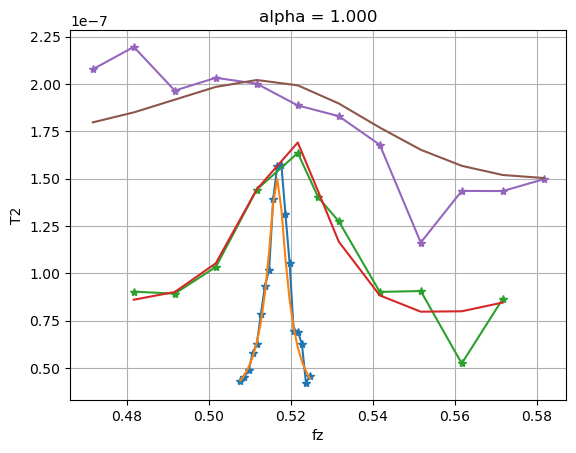

In [24]:
alpha = 1
res = least_squares(
    cost_func, 
    x0=[10, 6, 0.2],
    bounds=[[0, 0, -1], [20, 20, 1]],
    kwargs={"alpha":alpha, "include_error":True}
    )

cost_func(res.x, plot=True)
plt.title(f"{alpha = :.3f}")
print(res.x)
dc.c_fz_fx_to_non_prime(*res.x)

## T2 fit sweep alpha

In [25]:
test_alphas = np.linspace(0.96, 1.0, 2)
#test_alphas = np.linspace(0.85, 1.05, 21)

fits_res = []
for alpha in test_alphas:
    res = least_squares(
    cost_func,
    x0=[10, 6, 0.2],
    bounds=[[0, 0, -1], [20, 20, 1]],
    kwargs={"alpha":alpha}
    )
    fits_res.append(res)

In [26]:
fits = xr.DataArray(
    [[dc.Afz_to_non_prime(*res.x), res.x[1], dc.c_fz_fx_to_non_prime(*res.x), res.x[0], res.x[2]]for res in fits_res],
    coords=[test_alphas, ["Afz", "Afx", "cfzfx", "Afz_prime", "cfzfx_prime"]],
    dims=["alpha", "fit_param"]
)

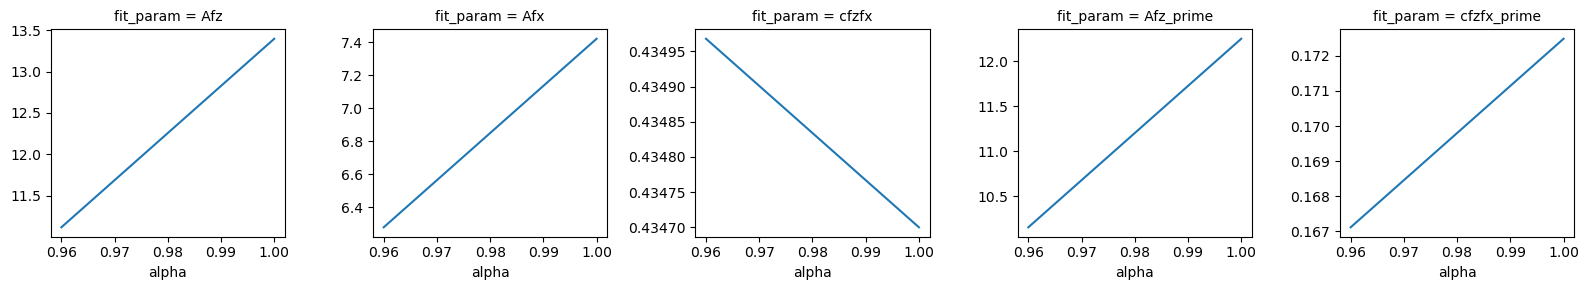

In [27]:
fits.plot(col="fit_param", sharey=False)

## get dense simulated T2 for figure

In [35]:
dense_sensitivity_data = [
    np.transpose(
        [
            [fx] * len(data["Data"]), 
            data['SweepSpecifiers'][0][1],
            [d["Average"]["dHdfz0011"] for d in data["Data"]],
            [d["Average"]["dHdfx0011"] for d in data["Data"]]
            ]
    )
    for fx, data in zip([0.32, 0.36, 0.4], fz_sensitivity_data)]

In [36]:
alpha = 1
_, Afx, _, Afzprime, cfzfx_prime = fits.loc[alpha]
dephasing_data = [
    [[d[1], dc.dephasing_tunable_csfq_flux_noise(
        float(d[2]) * 2 * np.pi * 1e9,
        float(d[3]) * 2 * np.pi * 1e9,
        float(Afzprime * 1e-6),
        float(Afx * 1e-6),
        float(cfzfx_prime),
        omega_low = 2 * np.pi / (1000 * 100e-6),
        tau = 100e-9,
        alpha=alpha
        ) * 1e6] for d in data] for data in dense_sensitivity_data
]

dephasing_data_echo = [
    [[d[1], dc.dephasing_tunable_csfq_flux_noise(
        float(d[2]) * 2 * np.pi * 1e9,
        float(d[3]) * 2 * np.pi * 1e9,
        float(Afzprime * 1e-6),
        float(Afx * 1e-6),
        float(cfzfx_prime),
        N = 1,
        omega_low = 2 * np.pi / (1000 * 100e-6),
        tau = 100e-9,
        alpha=alpha
        ) * 1e6] for d in data] for data in dense_sensitivity_data
]

In [29]:
for i, fx in enumerate(["32", "36", "40"]):
    data = dephasing_data[i]
    table_head = ["fz", "T2"]
    df = pd.DataFrame(data, columns=table_head)
    df.to_excel(f"Simulation/T2_vs_fz_fx={fx}_sim_alpha_{alpha}.xlsx", index=False)

In [29]:
#save T2 data versus fx 
alpha = 1
_, Afx, _, Afzprime, cfzfx_prime = fits.loc[alpha]

fx_sim = fx_sensitivity_data["SweepSpecifiers"][0][1]
estimated_T2E = [
    dc.dephasing_tunable_csfq_flux_noise(
        float(data["Average"]["dHdfz0011"]) * 2 * np.pi * 1e9,
        float(data["Average"]["dHdfx0011"]) * 2 * np.pi * 1e9,
        Afzprime * 1e-6,
        Afx * 1e-6,
        cfzfx_prime,
        #omega_low = 2 * np.pi / (1000 * 100e-6),
        #tau = 100e-9,
        N=1,
        alpha=alpha
        ) for data in fx_sensitivity_data["Data"]]
estimated_T2R = [
    dc.dephasing_tunable_csfq_flux_noise(
        float(data["Average"]["dHdfz0011"]) * 2 * np.pi * 1e9,
        float(data["Average"]["dHdfx0011"]) * 2 * np.pi * 1e9,
        Afzprime * 1e-6,
        Afx * 1e-6,
        cfzfx_prime,
        omega_low = 2 * np.pi / (1000 * 100e-6),
        tau = 100e-9,
        #N=1,
        alpha=alpha
        ) for data in fx_sensitivity_data["Data"]]

df = pd.DataFrame(
    np.transpose([fx_sim, estimated_T2R, estimated_T2E]), 
    columns=["Fx", "T2R (s)", "T2E (s)"]
)
df.to_excel("Simulation/T2_vs_fx_sim_alpha_1.xlsx", index=False)


# T1

In [38]:
#experiment data
T1_fx_data = []
for fx in [0.32, 0.36, 0.40]:
    file = pd.read_excel(f"Data/T1 vs fz {fx:.2f}.xls")
    T1_fx_data.append([(row[-1], row[1] * 1e-9) for row in file.iloc[1:].values])

T1_sym_file = pd.read_excel(f"Data/T1_T2_vs_fx.xls")
T1_sym_data = [(row[0], row[3] * 1e-9) for row in T1_sym_file.values]


In [39]:
#parameters for computing purcell decay
dfz = -0.0008839977974911532 #zero point fluctuation of resonator current * mutual inductancec
kappa = 12156896
omega_r = (7.8347 + 0.05) * 2 * np.pi * 1e9

Z0 = 50

def calc_all_t1(
        bv, #voltage noise constant, will leave as 0 
        vgamma, # voltage noise frequency exponent, 1 for ohmic
        bq, #charge noise constant, will leave as 0
        qgamma, #charge noise frequency exponent, 1 for ohmic
        bfz, #high frequency z flux noise constant
        fgamma, #flux noise frequency exponent, 1 for ohmic
        afz, #low frequency z flux noise amplitude
        afx, #low frequency x flux noise amplitude
        alpha, #low frequency flux noise frequency exponent, 1 for 1/f noise
        kappa, #resonator decay rate
        omega_r, #resonator frequency
        sensitivity_data, #device sensitivity data
        raw_data, #wiring data to compute effective noise temperature
        n_nodes=6, #number of qubit charge island, used for charge noise 
        Z0=Z0, #characteristic impedance
        thermal1f=False, #whether to consider phenomenological thermal model for 1/f flux noise
        x_bias=False): #whether to consider decay due to x_bias line noise. default to false because it has a cold open
    Lbz = raw_data['QubitLbz']['value']
    Mbz = raw_data['QubitMbz']['value']
    TOhmic = raw_data['TOhmic']['value']
    TRoom = raw_data['TRoom']['value']
    T3K = raw_data['T3K']['value']
    TStill = raw_data['TStill']['value']
    TMXC = raw_data['TMXC']['value']
    FzAtt3K = raw_data['QubitFzAtt3K']['value']
    FzAttStill = raw_data['QubitFzAttStill']['value']
    FzAttMXC = raw_data['QubitFzAttMXC']['value']
    Lbx = raw_data['QubitLbx']['value']
    Mbx = raw_data['QubitMbx']['value']
    FxAtt3K = raw_data['QubitFxAtt3K']['value']
    FxAttStill = raw_data['QubitFxAttStill']['value']
    FxAttMXC = raw_data['QubitFxAttMXC']['value']
    
    fx_t1_table = []
    for i in range(len(sensitivity_data['Data'])):
        g = dfz * sensitivity_data['Data'][i]['Average']['|dHdfz01|'] * 1e9 * 2 * np.pi
        dHdfz01 = sensitivity_data['Data'][i]['Average']['|dHdfz01|'] * 1e9
        dHdfx01 = sensitivity_data['Data'][i]['Average']['|dHdfx01|'] * 1e9
        Q01_sum = np.sum(sensitivity_data['Data'][i]['Average']['|Qn' + str(j+1) + '01|'] * 2 * dc.e_charge for j in range(n_nodes)) / 2 / np.pi
        V01_sum = np.sum(sensitivity_data['Data'][i]['Average']['|Vn' + str(j+1) + '01|'] * 1e-6 for j in range(n_nodes)) / dc.hbar / 2 / np.pi
        omega01 = sensitivity_data['Data'][i]['Average']['f01'] * 1e9 * 2 * np.pi
        TNoiseFz = dc.T_Noise_Q(omega01, [TRoom, T3K, TStill, TMXC], [FzAtt3K, FzAttStill, FzAttMXC])[-1]
        TNoiseFx = dc.T_Noise_Q(omega01, [TRoom, T3K, TStill, TMXC], [FxAtt3K, FxAttStill, FxAttMXC])[-1]

        afz_thermal = dc.A_simple_to_A_thermal((afz * 1e-6)**2, alpha, TOhmic)
        afx_thermal = dc.A_simple_to_A_thermal((afx * 1e-6)**2, alpha, TOhmic)
        
        gamma_purcell = dc.Gamma_purcell(g, kappa, omega_r, omega01)
        if thermal1f:
            gamma1_fz1f = dc.Gamma_1(dHdfz01, sum(dc.S_thermal_1f(omega, afz_thermal, alpha, TOhmic) for omega in [omega01, -omega01]))
            gamma1_fx1f = dc.Gamma_1(dHdfx01, sum(dc.S_thermal_1f(omega, afx_thermal, alpha, TOhmic) for omega in [omega01, -omega01]))
        else:
            gamma1_fz1f = dc.Gamma_1(dHdfz01, sum(dc.S_simple_1f(omega, afz * 1e-6, alpha) for omega in [omega01, -omega01]))
            gamma1_fx1f = dc.Gamma_1(dHdfx01, sum(dc.S_simple_1f(omega, afx * 1e-6, alpha) for omega in [omega01, -omega01]))
        
        gamma1_fz_bias = dc.Gamma_1(dHdfz01, sum(dc.S_flux_bias(omega, Z0, Lbz, Mbz, TNoiseFz) for omega in [omega01, -omega01]))
        gamma1_fx_bias = dc.Gamma_1(dHdfx01, sum(dc.S_flux_bias(omega, Z0, Lbx, Mbx, TNoiseFx) for omega in [omega01, -omega01]))
        gamma1_fz_ohmic = dc.Gamma_1(dHdfz01, sum(dc.S_ohmic(omega, bfz, fgamma, TOhmic) for omega in [omega01, -omega01]))
        gamma1_v_ohmic = dc.Gamma_1(Q01_sum, sum(dc.S_ohmic(omega, bv, vgamma, TOhmic) for omega in [omega01, -omega01]))
        gamma1_q_ohmic = dc.Gamma_1(V01_sum, sum(dc.S_ohmic(omega, bq, qgamma, TOhmic) for omega in [omega01, -omega01]))
        
        if not x_bias:
            gamma1_fx_bias = 1e-20
        
        gamma1_total = gamma_purcell + gamma1_fx1f + gamma1_fz1f + gamma1_fz_bias + gamma1_fx_bias + gamma1_fz_ohmic + gamma1_q_ohmic
        
        fx_t1_table.append({
            'bias': sensitivity_data['SweepSpecifiers'][0][1][i],
            'Gamma1Fx1f': gamma1_fx1f * 1e-6,
            'T1Fx1f': 1 / gamma1_fx1f / 1e-6,
            'Gamma1Fz1f': gamma1_fz1f * 1e-6,
            'T1Fz1f': 1 / gamma1_fz1f / 1e-6,
            'Gamma1FzOhmic': gamma1_fz_ohmic * 1e-6,
            'T1FzOhmic': 1 / gamma1_fz_ohmic / 1e-6,
            'Gamma1FzBias': gamma1_fz_bias * 1e-6,
            'T1FzBias': 1 / gamma1_fz_bias / 1e-6,
            'Gamma1FxBias': gamma1_fx_bias * 1e-6,
            'T1FxBias': 1 / gamma1_fx_bias / 1e-6,
            'Gamma1VOhmic': gamma1_v_ohmic * 1e-6,
            'T1VOhmic': 1 / gamma1_v_ohmic / 1e-6,
            'Gamma1QOhmic': gamma1_q_ohmic * 1e-6,
            'T1QOhmic': 1 / gamma1_q_ohmic / 1e-6,
            'GammaPurcell': gamma_purcell * 1e-6,
            'TPurcell': 1 / gamma_purcell / 1e-6,
            'GammaTotal': gamma1_total * 1e-6,
            'T1Total': 1 / gamma1_total / 1e-6
        })
    calc_T1s = {
        key: [item[key] for item in fx_t1_table] for key in fx_t1_table[0].keys()
    }
    return calc_T1s


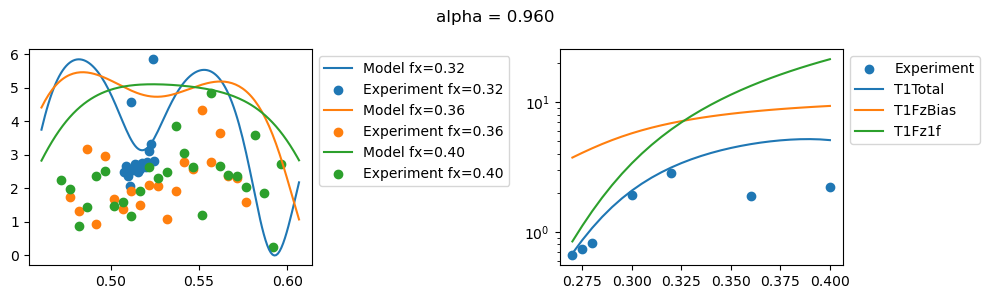

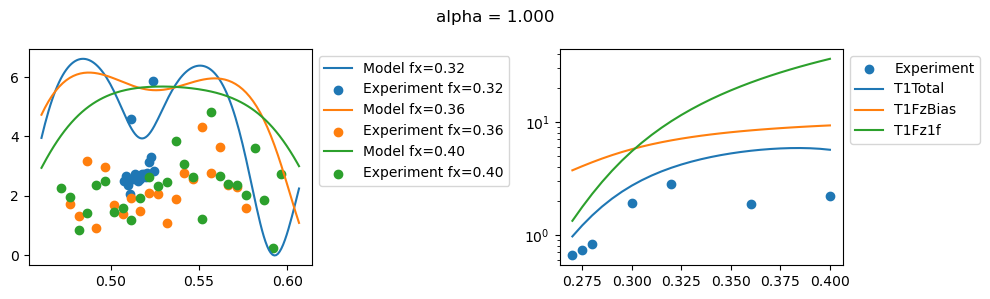

In [40]:
plot_keys = ["T1Total", "T1FzBias", "T1Fz1f"]#, "TPurcell"]
fx_fz_calculated_T1s = []
for i, (afz, afx, _, _, _) in enumerate(fits):
    alpha = fits.coords["alpha"][i]
    if alpha < 0.93 or alpha > 1:
        continue
    all_calc_T1s = [
        calc_all_t1(
            bv=1e-50, 
            vgamma=1, 
            bq=1e-90, 
            qgamma=1, 
            bfz=1e-50, 
            fgamma=1, 
            afz=afz, 
            afx=afx, 
            alpha=alpha, 
            kappa=kappa,
            omega_r=omega_r,
            sensitivity_data=data, 
            raw_data=ds,
            n_nodes=6,
            Z0=Z0,
            thermal1f=False, 
            x_bias=False) for data in fz_sensitivity_data + [fx_sensitivity_data]]
    fx_fz_calculated_T1s.append(all_calc_T1s)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    for i, ax in enumerate(axes):
        if i == 0:
            for j, fx in enumerate([0.32, 0.36, 0.40]):
                ax.plot(all_calc_T1s[j]["bias"], all_calc_T1s[j]["T1Total"], label=f"Model {fx=:.2f}")
                ax.scatter(np.array(T1_fx_data[j])[:,0], np.array(T1_fx_data[j])[:,1] * 1e6, label=f"Experiment {fx=:.2f}")
            ax.legend(bbox_to_anchor=(1, 1))
        else:
            ax.scatter(np.array(T1_sym_data)[:,0], np.array(T1_sym_data)[:,1] * 1e6, label="Experiment")
            for key in plot_keys:
                ax.plot(all_calc_T1s[3]["bias"], all_calc_T1s[3][key], label=key)   
            ax.legend(bbox_to_anchor=(1, 1))
            ax.set_yscale("log")
    plt.suptitle(f"{alpha = :.3f}")
    plt.tight_layout()
    plt.show()

In [42]:
# The closest that is still above the data is alpha=0.96
all_calc_T1s_96 = fx_fz_calculated_T1s[0]
all_calc_T1s_1 = fx_fz_calculated_T1s[-1]
for fx, data in zip([0.32, 0.36, 0.40], all_calc_T1s_96[:3]):
    table_head = list(data.keys())
    table = [[float(v) for v in value] for value in data.values()]
    df = pd.DataFrame(np.transpose(table), columns=table_head)
    df.to_excel(f"Simulation/T1_vs_fz_sim_{fx:.2f}_alpha_96.xlsx", index=False)

for fx, data in zip([0.32, 0.36, 0.40], all_calc_T1s_1[:3]):
    table_head = list(data.keys())
    table = [[float(v) for v in value] for value in data.values()]
    df = pd.DataFrame(np.transpose(table), columns=table_head)
    df.to_excel(f"Simulation/T1_vs_fz_sim_{fx:.2f}_alpha_1.xlsx", index=False)

data = all_calc_T1s_96[-1]
table_head = list(data.keys())
table = [[float(v) for v in value] for value in data.values()]
df = pd.DataFrame(np.transpose(table), columns=table_head)
df.to_excel(f"Simulation/T1_vs_fx_sim_alpha_96.xlsx", index=False)

data = all_calc_T1s[-1]
table_head = list(data.keys())
table = [[float(v) for v in value] for value in data.values()]
df = pd.DataFrame(np.transpose(table), columns=table_head)
df.to_excel(f"Simulation/T1_vs_fx_sim_alpha_1.xlsx", index=False)



# Other test

##  Fit T2 vs fx

In [55]:

fx_sim = fx_sensitivity_data["SweepSpecifiers"][0][1]
fx_sensitivities = fx_sensitivity_data["Data"]
T2_sym_file = pd.read_excel(f"Data/T1_T2_vs_fx.xls")
T2R_sym_data = np.array([(row[0], row[7] * 1e-9) for row in T2_sym_file.values])
T2E_sym_data = np.array([(row[0], row[11] * 1e-9) for row in T2_sym_file.values])


In [56]:

alpha = 0.96
Afzprime, Afx, cfzprimefx = [9.77639113, 6.50785689, 0.21141324]
alpha = 1
Afzprime, Afx, cfzprimefx = [11.69116721,  7.7188209,   0.22086751]
# alpha = 1.05
# Afzprime, Afx, cfzprimefx = [14.39473857,  9.40626824,  0.23269887]

estimated_T2E = [
    dc.dephasing_tunable_csfq_flux_noise(
        float(data["Average"]["dHdfz0011"]) * 2 * np.pi * 1e9,
        float(data["Average"]["dHdfx0011"]) * 2 * np.pi * 1e9,
        Afzprime * 1e-6,
        Afx * 1e-6,
        cfzprimefx,
        #omega_low = 2 * np.pi / (1000 * 100e-6),
        #tau = 100e-9,
        N=1,
        alpha=alpha
        ) for data in fx_sensitivities]
estimated_T2R = [
    dc.dephasing_tunable_csfq_flux_noise(
        float(data["Average"]["dHdfz0011"]) * 2 * np.pi * 1e9,
        float(data["Average"]["dHdfx0011"]) * 2 * np.pi * 1e9,
        Afzprime * 1e-6,
        Afx * 1e-6,
        cfzprimefx,
        omega_low = 2 * np.pi / (1000 * 100e-6),
        tau = 100e-9,
        #N=1,
        alpha=alpha
        ) for data in fx_sensitivities]

Text(0, 0.5, 'Coherence time (s)')

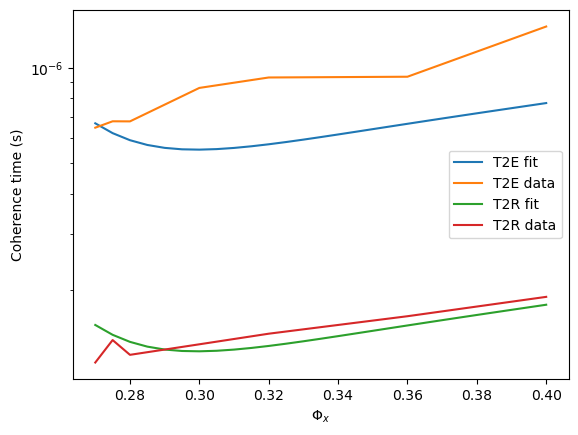

In [57]:
plt.plot(fx_sim, estimated_T2E, label="T2E fit")
plt.plot(*T2E_sym_data.T, label="T2E data")
#plt.show()
plt.plot(fx_sim, estimated_T2R, label="T2R fit")
plt.plot(*T2R_sym_data.T, label="T2R data")
plt.yscale("log")
plt.legend()
plt.xlabel(r"$\Phi_x$")
plt.ylabel("Coherence time (s)")

Text(0, 0.5, 'Sensitivity (GHz$/\\Phi_0)$')

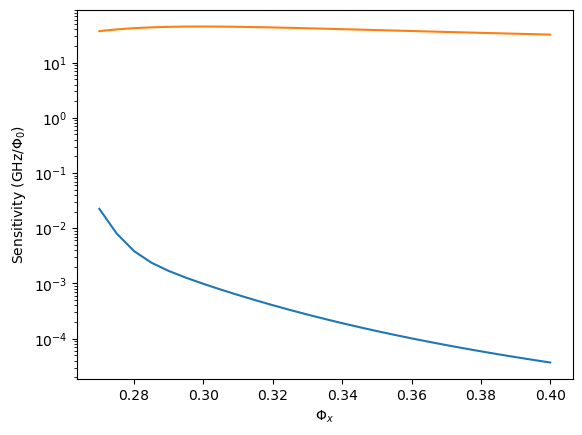

In [62]:
fx_dfz_data = [data["Average"]["dHdfz0011"] for data in fx_sensitivities]
fx_dfx_data = [data["Average"]["dHdfx0011"] for data in fx_sensitivities]
plt.plot(fx_sim, fx_dfz_data)
plt.plot(fx_sim, fx_dfx_data)
plt.yscale("log")
plt.xlabel(r"$\Phi_x$")
plt.ylabel(r"Sensitivity (GHz$/\Phi_0)$")

In [65]:
Afzprime = 1e-12
cfzprimefx = 0

soft_l1 = lambda z: 2 * ((1 + z)**0.5 - 1)
cauchy = lambda z: np.log(1 + z)
f_scale = 1000
def cost_func(x, alpha=1, plot=False):
    Afx = x
    estimated_T2R = []
    for fx in T2R_sym_data[1:,0]:
        idx = np.argmin(np.abs(fx - fx_sim))
        data = fx_sensitivities[idx]
        T2R = dc.dephasing_tunable_csfq_flux_noise(
            float(data["Average"]["dHdfz0011"]) * 2 * np.pi * 1e9,
            float(data["Average"]["dHdfx0011"]) * 2 * np.pi * 1e9,
            Afzprime * 1e-6,
            Afx * 1e-6,
            cfzprimefx,
            omega_low = 2 * np.pi / (1000 * 100e-6),
            tau = 100e-9,
            #N=1,
            alpha=alpha
            )
        estimated_T2R.append(T2R)
    sq_loss = (np.array(estimated_T2R) * 1e9 - T2R_sym_data[1:,1] * 1e9) ** 2
    cost = sq_loss.sum()
    #cost = f_scale ** 2 * soft_l1(sq_loss / f_scale ** 2).sum()
    #cost = f_scale ** 2 * cauchy(sq_loss / f_scale ** 2).sum()
    if plot:
        #print (estimated_dephasings)
        #fig, axes = plt.subplots(ncols=len(fx_data), nrows=1, figsize=(7, 4))
        fig, ax = plt.subplots()
        #for i, ax in enumerate(axes):
        ax.scatter(*T2R_sym_data.T, label="T2R data")
        ax.plot(T2R_sym_data[1:,0], estimated_T2R, label="T2R fit")
        ax.grid(True)
        ax.legend()
    #print (cost)
    return cost

[7.62861915]
389738451.92027646
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 2.792e+04]
           x: [ 7.629e+00]
        cost: 389738451.92027646
         jac: [[-3.472e-01]]
        grad: [-9.693e+03]
  optimality: 119912.26274152433
 active_mask: [0]
        nfev: 20
        njev: 13


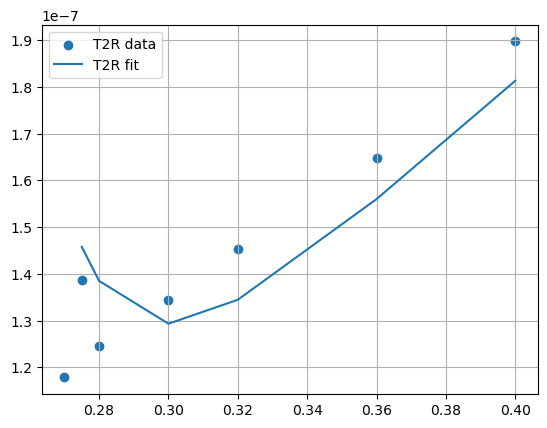

In [66]:
alpha = 1
res = least_squares(
    cost_func, 
    x0=[5],
    bounds=[0, 20],
    kwargs={"alpha":alpha}
    )

cost_func(res.x, alpha=alpha, plot=True)
print (res.x)
print (res.cost)
print (res)

618.3887333927654

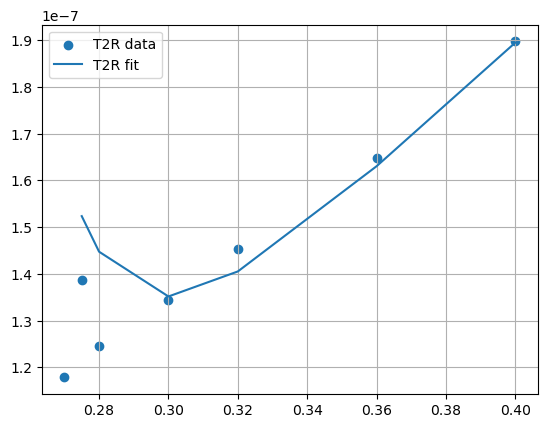

In [67]:
cost_func(7.3, alpha=alpha, plot=True)

## T2 combined fx, fz fit with error

In [71]:
def T2_residual(
    x, 
    alpha=1, 
    N=0,
    vs_fz=True, 
    vs_fx=True,
    plot=False):
    Afzprime, Afx, cfzprimefx = x
    res = []
    if vs_fz:
        estimated_T2_fz = [
            [dc.dephasing_tunable_csfq_flux_noise(
                float(data["dHdfz0011"][i]) * 2 * np.pi * 1e9,
                float(data["dHdfx0011"][i]) * 2 * np.pi * 1e9,
                Afzprime * 1e-6,
                Afx * 1e-6,
                cfzprimefx,
                omega_low = 2 * np.pi / (1000 * 100e-6),
                tau = 100e-9,
                alpha=alpha
                )for i in range(len(data["fz"]))] for data in T2_fz_data
        ]

        for i in range(len(T2_fz_data)):
            #print ("exp length", len(T2_fz_data[i]["fz"]))
            #print ("estimated length", len(estimated_T2_fz[i]))
            for j in range(len(T2_fz_data[i]["fz"])):
                #print ("esimated", estimated_T2_fz[i][j])
                #print ("measured", float(T2_fz_data[i]["T2"][j]))
                #print ("error", float(T2_fz_data[i]["T2_err"][j]))
                diff = estimated_T2_fz[i][j] * 1e9 - float(T2_fz_data[i]["T2"][j])
                this_res = diff / float(T2_fz_data[i]["T2_err"][j]) 
                res.append(this_res)
    if vs_fx:
        estimated_T2_fx = []
        
        for fx in np.array(T2_sym_file["fx"]):
            data = fx_sensitivity_da.sel(fx=fx, method="nearest")
            T2R = dc.dephasing_tunable_csfq_flux_noise(
                float(data["dHdfz0011"]) * 2 * np.pi * 1e9,
                float(data["dHdfx0011"]) * 2 * np.pi * 1e9,
                Afzprime * 1e-6,
                Afx * 1e-6,
                cfzprimefx,
                omega_low = 2 * np.pi / (1000 * 100e-6),
                tau = 100e-9,
                N=N,
                alpha=alpha
                )
            estimated_T2_fx.append(T2R)
        if N == 0:
            data = np.array(T2_sym_file["<T2R>"])
            err = np.array(T2_sym_file["T2R err"])
        elif N == 1:
            data = np.array(T2_sym_file["<T2E>"])
            err = np.array(T2_sym_file["T2E err"])
        for i in range(len(estimated_T2_fx)):
            res.append((estimated_T2_fx[i] * 1e9 - data[i]) / err[i])
    if plot:

        fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(7, 4))
        if vs_fz:
            for i in range(len(T2_fz_data)):
                axes[0].errorbar(
                    T2_fz_data[i]["fz"], 
                    T2_fz_data[i]["T2"], 
                    T2_fz_data[i]["T2_err"], marker="*", label="")
                axes[0].plot(T2_fz_data[i]["fz"], np.array(estimated_T2_fz[i]) * 1e9)
                axes[0].grid(True)
        #for i, ax in enumerate(axes):
        if vs_fx:
            axes[1].errorbar(T2_sym_file["fx"], data, err, marker="*")
            axes[1].plot(T2_sym_file["fx"], np.array(estimated_T2_fx) * 1e9)
            axes[1].grid(True)
    return res

def T2_fit(
    x0,
    alpha=1, 
    N=0,
    vs_fz=True, 
    vs_fx=True):
    res = least_squares(T2_residual, x0=x0, loss="soft_l1", jac="3-point", kwargs=dict(alpha=alpha, vs_fz=vs_fz, vs_fx=vs_fx, N=0))

    # Do Moore-Penrose inverse discarding zero singular values.
    _, s, VT = np.linalg.svd(res.jac, full_matrices=False)
    threshold = np.finfo(float).eps * max(res.jac.shape) * s[0]
    s = s[s > threshold]
    VT = VT[:s.size]
    pcov = np.dot(VT.T / s**2, VT)
    
    return res.x, pcov

[12.15384902  7.61140744  0.19637902]
[0.13503518 0.06980001 0.01456103]


[0.1449578107361766,
 1.3936876779037295,
 2.162508040936749,
 -1.4775029694365729,
 0.24691273878028763,
 -3.3591593087911096,
 -2.162884694345477,
 4.5878867108368535,
 -1.3046391917364957,
 -4.925473638765531,
 -14.654169927574852,
 -15.905848743507514,
 -16.917341402378,
 -0.5883788673559035,
 -2.6513009289308367,
 -8.29590830466367,
 1.0964027645338619,
 -1.1790356573761342,
 -1.5191937027538742,
 0.1001032685138891,
 0.9294736771407304,
 0.8657762485201957,
 0.6147719665175222,
 -1.219107261736868,
 -11.896517122459743,
 -4.219067011754828,
 -4.869531121395397,
 11.977883551139202,
 -1.0110567826760004,
 -3.1729306808172972,
 -0.8419312972645272,
 -0.5880282809003727,
 -1.5869790006143378,
 0.5533928184260882,
 3.5283057209739295,
 0.4145927309136764,
 1.0462839768880348,
 9.72272194736434,
 5.82398659933008,
 2.5560235971248177,
 -1.1696100468150723,
 0.20549844648608526,
 -0.8628225988740246,
 -2.204937291967054,
 -22.327568642431043,
 -5.033464600728017,
 -5.427073845128077,
 

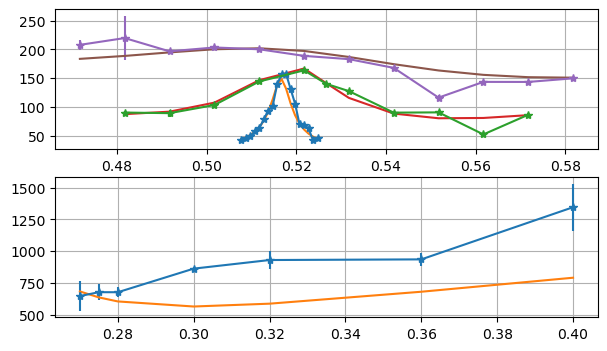

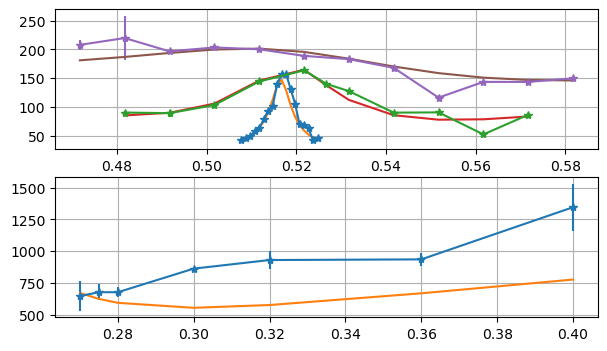

In [80]:
alpha = 1
_, Afx, _, Afzprime, cfzfx_prime = fits.loc[alpha]

popt, pcov = T2_fit(x0=[Afzprime, Afx, cfzfx_prime])
print (popt)
print (np.sqrt(np.diag(pcov)))
T2_residual(popt - np.sqrt(np.diag(pcov)), plot=True, alpha=alpha, N=1)
T2_residual(popt + np.sqrt(np.diag(pcov)), plot=True, alpha=alpha, N=1)

/Users/xidai/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofWaterloo/SQDQEO - Papers/AnnealingCSFQDecoherence/AnalysisData/20240505_RedoCoherenceFitPython/decoherence.py:105: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Afz_prime ** 2 + c_fz_prime_fx * Afz_prime * Afx
/Users/xidai/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofWaterloo/SQDQEO - Papers/AnnealingCSFQDecoherence/AnalysisData/20240505_RedoCoherenceFitPython/decoherence.py:105: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Afz_prime ** 2 + c_fz_prime_fx * Afz_prime * Afx
/Users/xidai/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofWaterloo/SQDQEO - Papers/AnnealingCSFQDecoherence/AnalysisData/20240505_RedoCoherenceFitPython/decoherence.py:105: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Afz_prime ** 2 + c_fz_prime_fx * Afz_prime * Afx
/Users/xidai/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofWaterloo/SQDQEO - Paper

[18.48516125 11.09414865  0.22215934]
[0.22858746 0.10292997 0.01322395]


[1.9418038253588423,
 3.0642447757190214,
 3.515782136601574,
 -0.8994314048992428,
 0.4038307482995163,
 -3.10755322919825,
 -2.16319930217093,
 4.5760645569431775,
 -0.5278072302614939,
 -3.8710135793402136,
 -13.918290735317022,
 -15.44075418178952,
 -16.355906068170835,
 -0.06671589405449024,
 -2.398412906904637,
 -7.475778699798178,
 1.3466462337179559,
 -0.6654692294105694,
 -1.767101383240357,
 -0.05217706043315836,
 0.4037731796568216,
 0.1294428860719832,
 1.2689402988206846,
 -1.1548839340459696,
 -12.121205937786488,
 -4.419659972659609,
 -4.947199538502916,
 11.803242504080542,
 -1.2448851403458647,
 -3.953248533027844,
 -0.9946226795523326,
 -1.5940885685825443,
 -2.9066086251848784,
 0.04540952109316734,
 3.546870981615836,
 0.30523815985929054,
 0.5435497963891632,
 9.24535759025887,
 3.560779647598037,
 -0.08687287242620796,
 -2.47790730269209,
 2.1332894655141743,
 2.621137130965128,
 3.188860449292152,
 -8.355929769222051,
 -2.2032877793383023,
 -0.8610698707620492,
 

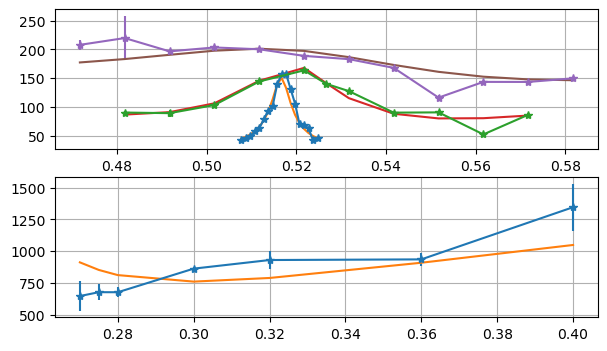

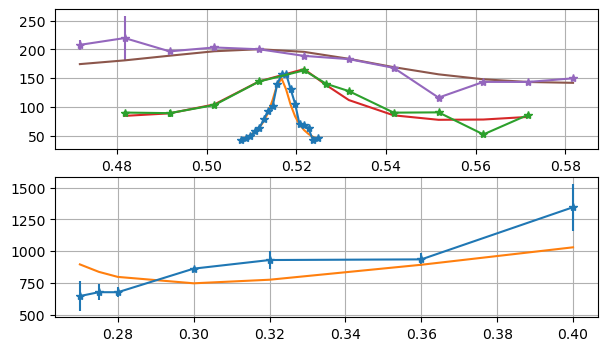

In [78]:
alpha = 1.1
popt, pcov = T2_fit(x0=[11.69116721,  7.7188209,   0.22086751], alpha=alpha, N=1)
print (popt)
print (np.sqrt(np.diag(pcov)))
T2_residual(popt - np.sqrt(np.diag(pcov)), plot=True, alpha=alpha, N=1)
T2_residual(popt + np.sqrt(np.diag(pcov)), plot=True, alpha=alpha, N=1)